# DGEB Final Project Notebook: Traditional Models for Convergent Enzyme Classification

## Authors: Mahbuba Tasmin & Bryn Reimer  
Course: CS 690U — Spring 2025  
Date: April 2025

## Objective

We aim to benchmark the performance of the following traditional approaches:
- **Logistic regression** trained on one-hot encoded DNA sequences (512 bp max) as well as $k$-mer count features and amino acid properties-based encoding.
- **BLAST**-based nearest-neighbor prediction using top alignment match from training data.

The remainder of this notebook is structured as follows:
1. Dataset loading and pre-processing
2. One-hot encoding
3. $k$-mer encoding
4. Count encoding
5. Properties encoding
6. Logistic regression with pytorch
7. BLAST-based baseline 1
8. BLAST-based baseline 2
9. ESM embeddings




## Dataset loading and pre-processing


In [28]:
from ce_utils import *

In [29]:
# Initial data were downloaded from the web using load_and_save_dataset.py
df_train = pd.read_pickle('data/train_dataset.pkl')
df_test = pd.read_pickle('data/test_dataset.pkl')

In [30]:
print(f"Train set: {df_train.shape}")
print(f"Test set: {df_test.shape}")

Train set: (2000, 3)
Test set: (400, 3)


In [31]:
df_test.head(2)

,Entry,Label,Sequence
0,Q9P7T7,2.7.7.1,MDQAKKYANLLDSFRSSTEDILLLERLEVSDKPIYVLDSSFNPPHFAHLGMCLSIPKGSQLLLLLSITNADKPVAPAAFNERILMMEKLKTLIHNCTVSVAICKHALFVDKCRSISNKLGPREQVYLVGFDTLIRILDCKYYKEKAMQQVLQPFFSCSQILCFSREVDGTTTDDQAQYLEKIKKSLLPNIPSQWSEKIKLTKLKGNVGFGVSSTRARQAIISGDEETQRKIIPQEILNVIKVIQPYRHR
1,Q9M8R4,4.4.1.5,MANSRTVLILCGDYMEDYEVMVPFQALQAFGITVHTVCPGKKAGDSCPTAVHDFCGHQTYFESRGHNFTLNATFDEVDLSKYDGLVIPGGRAPEYLALTASVVELVKEFSRSGKPIASICHGQLILAAADTVNGRKCTAYATVGPSLVAAGAKWVEPITPDVCVVDGSLITAATYEGHPEFIQLFVKALGGKITGANKRILFLCGDYMEDYEVKVPFQSLQALGCQVDAVCPEKKAGDRCPTAIHDFEGDQTYSEKPGHTFALTTNFDDLVSSSYDALVIPGGRAPEYLALNEHVLNIVKEFMNSEKPVASICHGQQILAAAGVLKGRKCTAYPAVKLNVVLGGGTWLEPDPIDRCFTDGNLVTGAAWPGHPEFVSQLMALLGIQVSF


In [32]:
df_train.head(5) # take a peek at the data

,Entry,Label,Sequence
0,A6UQM3,2.7.7.1,MRAFIVGRWQPFHKGHLEIIKKISEEVDEIIIGIGSCQRSHTLTDPFTAGERIMMITKALGRYNINYYIIPINDIDFNAVWVSCVESLTPPFDTVYTGNSLVRELFSEKNYVVKKPELYNRKEYSGTEIRKKMLKGEKWEHFVPEEVVDVILEIDGIGRIKRLDEKDYDDYF
1,A2SS82,2.7.7.1,MRRGLYVGRFQPFHNGHKAVIDGLAEEVDELIIGIGSADISHDIRHPFTAGERVLMITRALNGLKIPFYVIPLEDVKRNALWVAHVKSMVPPFDTVYTSNPLVIQLFKEAGIPVLSPPMYLRESLSGTAVRKKMYHGEAWEEYVPKEVVSVVGEIHGIERMQQISKSD
2,A0B5N0,2.7.7.1,MRRGFYIGRFQPYHMGHHLVLEQISREVDEIIVGIGTAQISHTVTDPFTAGERIAMIYGALRELGRWFYIIPLPDINRNAVWVSHVKSMTPPFEVVYSNNPLVVELFMEAGMEVRRPPMYRREVYSGTVIRRLMIEGGDWRQLVPDAVAKVIDEIKGVERLRNISKKDFA
3,Q9UXN8,2.7.7.1,MRRAFYIGRFQPFHLGHYSLIKDIARDADEVVIGIGSAQKSHEPKNPFTAGERVMMIKHALEDAGIKHYAIPLEDLQRNAVWVSHIISMTPPFDVVYSNNPLVVRLFQESGILVEQPPMYQREGYSGSEIRKRMLRGEDWKSLVPAAVIDVIDEIDGVNRLKSVSKSDKDYRD
4,B0R328,2.7.7.1,MTRGFYIGRFQPFHTGHRRVIEQIATEVDELVVGIGSAGDSHSARNPFTAGERIMMITKALVEFNLVTYAVPIEDLERNAVWVSHVRSMCPKFEVAYSNNPLVIRLFNEAAVEVRQPPMYDRDVLEGAEIRRRMADGDDWESLVPDAVADVVAEIDGVERIQHVADTDANGHDSGLR


count    2000.00000
mean      415.43800
std       276.45399
min        55.00000
25%       239.00000
50%       348.00000
75%       514.50000
max      3004.00000
Name: Sequence, dtype: float64


<Axes: title={'center': 'Sequence lengths across training samples'}, xlabel='Sequence length', ylabel='Frequency'>

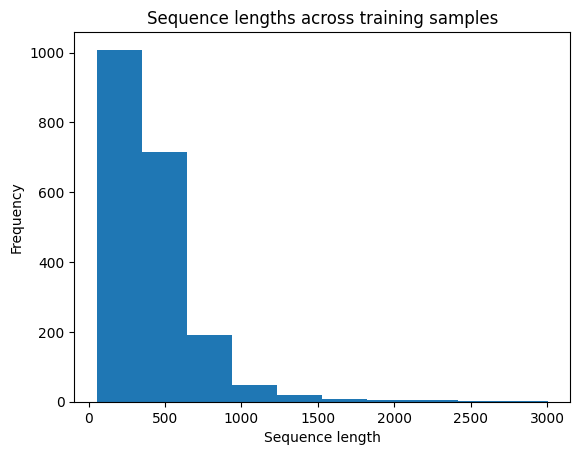

In [33]:
# check sequence lengths
seq_lengths = df_train["Sequence"].apply(len)

print(seq_lengths.describe())

seq_lengths.plot.hist(xlabel="Sequence length", 
                      ylabel="Frequency", 
                      title="Sequence lengths across training samples")

<Axes: title={'center': 'Sequence lengths across test samples'}, xlabel='Sequence length', ylabel='Frequency'>

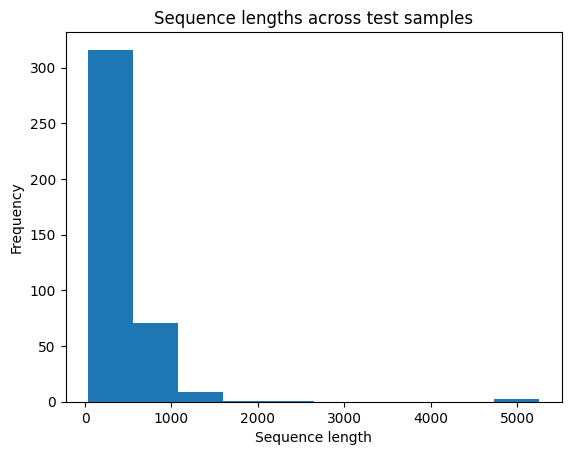

In [34]:
# check sequence lengths
test_seq_lengths = df_test["Sequence"].apply(len)

test_seq_lengths.plot.hist(xlabel="Sequence length", 
                      ylabel="Frequency", 
                      title="Sequence lengths across test samples")

## One-hot encoding

In [35]:
# Define the standard 20 amino acids
# Plus U for selenocysteine which is present in some of our samples
AMINO_ACIDS = "ACDEFGHIKLMNPQRSTUVWY"

def one_hot_encode_protein(seq, max_len=512):
    encoding = np.zeros((max_len, len(AMINO_ACIDS)), dtype=np.int8)
    for i, aa in enumerate(seq[:max_len]):
        if aa != "X":
            encoding[i, AMINO_ACIDS.index(aa)] = 1
    return encoding.flatten()  # Shape: (max_len * 21,)

In [36]:
## Apply encoding to all sequences, full length
X_train = np.stack(df_train["Sequence"].map(lambda s: one_hot_encode_protein(s, max_len=3004)))
X_test = np.stack(df_test["Sequence"].map(lambda s: one_hot_encode_protein(s, max_len=3004)))

# Check shape
print(f"One-hot encoded train set shape: {X_train.shape}")
print(f"One-hot encoded test set shape: {X_test.shape}")

One-hot encoded train set shape: (2000, 63084)
One-hot encoded test set shape: (400, 63084)


## $k$-mer encoding

In [37]:
from collections import Counter
from itertools import product

def kmer_features_protein(seq, k=3):
    # Define k-mer vocabulary from 20 amino acids
    vocab = [''.join(p) for p in product(AMINO_ACIDS, repeat=k)]
    counts = Counter([seq[i:i+k] for i in range(len(seq)-k+1)])
    return np.array([counts.get(kmer, 0) for kmer in vocab], dtype=np.float32)

X_train_kmer = np.stack(df_train["Sequence"].map(lambda s: kmer_features_protein(s, k=3)))
X_test_kmer = np.stack(df_test["Sequence"].map(lambda s: kmer_features_protein(s, k=3)))

print("Shape of 3-mer train feature matrix:", X_train_kmer.shape)
print("Shape of 3-mer test feature matrix:", X_test_kmer.shape)

Shape of 3-mer train feature matrix: (2000, 9261)
Shape of 3-mer test feature matrix: (400, 9261)


## Count encoding

In [38]:
def count_features_protein(seq):
    vocab = list(AMINO_ACIDS)
    counts = Counter([seq[i:i+1] for i in range(len(seq)-1+1)])
    return np.array([counts.get(kmer, 0) for kmer in vocab], dtype=np.float32)

X_train_count = np.stack(df_train["Sequence"].map(lambda s: count_features_protein(s)))
X_test_count = np.stack(df_test["Sequence"].map(lambda s: count_features_protein(s)))


print("Shape of count-encoded train feature matrix:", X_train_count.shape)
print("Shape of count-encoded test feature matrix:", X_test_count.shape)

Shape of count-encoded train feature matrix: (2000, 21)
Shape of count-encoded test feature matrix: (400, 21)


## Physico-chemical amino acid descriptors

In [39]:
# !pip install peptides
import peptides

def encode_peptide(s):
    return peptides.Peptide(s).descriptors()

X_train_properties = pd.DataFrame([ peptides.Peptide(s).descriptors() for s in df_train["Sequence"].to_list() ])
X_test_properties = pd.DataFrame([ peptides.Peptide(s).descriptors() for s in df_test["Sequence"].to_list() ])

print("Shape of properties-based train feature matrix:", X_train_properties.shape)
print("Shape of properties-based test feature matrix:", X_test_properties.shape)

Shape of properties-based train feature matrix: (2000, 102)
Shape of properties-based test feature matrix: (400, 102)


## Logistic Regression with Pytorch

In [40]:
from ce_utils import run_logistic_regression

## Encode EC labels as integer labels
le = LabelEncoder()
y_train = le.fit_transform(df_train["Label"])
y_test = le.transform(df_test["Label"])

# Optional: Show label classes
print("Classes:", le.classes_)

Classes: ['1.1.1.1' '1.1.1.103' '1.1.1.169' '1.1.1.17' '1.1.1.2' '1.1.1.27'
 '1.1.1.35' '1.1.1.37' '1.1.1.42' '1.1.1.47' '1.1.5.3' '1.11.1.24'
 '1.11.1.28' '1.11.1.5' '1.11.1.6' '1.11.1.7' '1.12.98.1' '1.13.11.24'
 '1.14.11.27' '1.14.13.25' '1.14.13.39' '1.14.14.18' '1.14.18.1'
 '1.14.99.60' '1.15.1.1' '1.16.1.9' '1.16.3.1' '1.17.1.4' '1.17.1.9'
 '1.17.4.1' '1.17.99.6' '1.17.99.9' '1.18.1.2' '1.18.1.3' '1.18.6.1'
 '1.2.1.10' '1.2.4.1' '1.2.4.4' '1.2.7.1' '1.2.7.12' '1.2.7.3' '1.20.4.1'
 '1.3.1.104' '1.3.1.9' '1.3.5.1' '1.3.7.7' '1.4.1.1' '1.4.1.13' '1.4.1.2'
 '1.4.3.5' '1.5.1.2' '1.5.1.3' '1.5.1.36' '1.5.1.42' '1.5.3.24' '1.5.98.3'
 '1.6.5.2' '1.6.5.9' '1.7.5.1' '1.8.1.2' '1.8.1.8' '1.8.1.9' '1.8.3.2'
 '1.97.1.12' '2.1.1.17' '2.1.1.228' '2.1.1.320' '2.1.1.33' '2.1.1.355'
 '2.1.1.37' '2.1.1.56' '2.1.1.57' '2.1.1.72' '2.1.1.85' '2.1.1.86'
 '2.1.3.15' '2.2.1.6' '2.3.1.1' '2.3.1.15' '2.3.1.180' '2.3.1.181'
 '2.3.1.184' '2.3.1.199' '2.3.1.20' '2.3.1.225' '2.3.1.28' '2.3.1.30'
 '2.3.1.31' '2

In [42]:

(acc, f1, num_corr) = run_logistic_regression(X_train, y_train, X_test, y_test, 
                                              n_epochs=100, verbose=False)
print(f"One-hot encoding Accuracy: {acc:.4f}, F1-score: {f1:0.4f}, Num correct: {num_corr}")

for k in [1,2,3,4]:
    print("---")
    X_train_kmer = np.stack(df_train["Sequence"].map(lambda s: kmer_features_protein(s, k=k)))
    X_test_kmer = np.stack(df_test["Sequence"].map(lambda s: kmer_features_protein(s, k=k)))
    (acc, f1, num_corr) = run_logistic_regression(X_train_kmer, y_train, X_test_kmer, y_test, 
                                              n_epochs=100, verbose=False)
    print(f"{k}-mer Accuracy: {acc:.4f}, F1-score: {f1:0.4f}, Num correct: {num_corr}")


print("---")
(acc, f1, num_corr) = run_logistic_regression(X_train_count, y_train, X_test_count, y_test, 
                                              n_epochs=1000, verbose=False)
print(f"Count Encoding Accuracy: {acc:.4f}, F1-score: {f1:0.4f}, Num correct: {num_corr}")


One-hot encoding Accuracy: 0.0250, F1-score: 0.0168, Num correct: 10
---
1-mer Accuracy: 0.0025, F1-score: 0.0003, Num correct: 1
---
2-mer Accuracy: 0.0300, F1-score: 0.0181, Num correct: 12
---
3-mer Accuracy: 0.0175, F1-score: 0.0107, Num correct: 7
---
4-mer Accuracy: 0.0075, F1-score: 0.0019, Num correct: 3
---
Count Encoding Accuracy: 0.0200, F1-score: 0.0179, Num correct: 8


In [26]:
print("---")
(acc, f1, num_corr) = run_logistic_regression(np.array(X_train_properties), y_train, 
                                              np.array(X_test_properties), y_test, 
                                              n_epochs=1000, verbose=False)
print(f"Properties Encoding Accuracy: {acc:.4f}, F1-score: {f1:0.4f}, Num correct: {num_corr}")

---
Properties Encoding Accuracy: 0.0150, F1-score: 0.0104, Num correct: 6


## Using BLAST to find nearest-neighbors

### Blast Approach 1

In [17]:
#step 1: write sequences to fasta
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

# Write training sequences
train_records = [
    SeqRecord(Seq(seq), id=entry, description=label)
    for seq, entry, label in zip(df_train["Sequence"], df_train["Entry"], df_train["Label"])
]
SeqIO.write(train_records, "data/train_set_for_blast.fasta", "fasta")

# Write test sequences
test_records = [
    SeqRecord(Seq(seq), id=entry, description=label)
    for seq, entry, label in zip(df_test["Sequence"], df_test["Entry"], df_test["Label"])
]
SeqIO.write(test_records, "data/test_set_for_blast.fasta", "fasta")


400

In [37]:
# #run this from terminal and save the blast results.txt 
# #step 2 : create BLAST DB
# !makeblastdb -in train_set_for_blast.fasta -dbtype prot -out train_db
# # step 3- run blast
# !blastp -query test_set_for_blast.fasta -db train_db -outfmt "6 qseqid sseqid pident length" -out blast_results.txt

In [21]:

# Load BLAST results
blast_df = pd.read_csv("data/blast_results.txt", sep="\t", header=None,
                       names=["query", "subject", "pident", "length", "bitscore"])

entry_to_label = dict(zip(df_train["Entry"], df_train["Label"]))
true_labels = dict(zip(df_test["Entry"], df_test["Label"]))

# Predict using top BLAST hit
blast_df["pred_label"] = blast_df["subject"].map(entry_to_label)
blast_df["true_label"] = blast_df["query"].map(true_labels)

# Drop NA (if any query had no match)
blast_df = blast_df.dropna(subset=["pred_label", "true_label"])

from sklearn.metrics import accuracy_score, f1_score

y_true = blast_df["true_label"]
y_pred = blast_df["pred_label"]

print(f"BLAST Accuracy: {accuracy_score(y_true, y_pred):0.4f}")
print(f"BLAST Macro F1: {f1_score(y_true, y_pred, average='macro'):0.4f}")
print(f"Num correct: {sum(y_true == y_pred)}")

BLAST Accuracy: 0.0019
BLAST Macro F1: 0.0008
Num correct: 6


In [19]:
## check for missing predictions
missed = set(df_test["Entry"]) - set(blast_df["query"])
print(f"{len(missed)} test sequences had no BLAST hits.")

1 test sequences had no BLAST hits.


### BLAST Approach 2

In [29]:
from Bio import Align
import pickle

## WARNING this takes about an hour to run
fine_with_long_runtime = False

if fine_with_long_runtime:
    aligner = Align.PairwiseAligner(scoring="blastp")
    
    results = {
        "true": df_test.Label,
        "best_1": ["" for _ in range(len(df_test.Label))],
        "best_10_NN": ["" for _ in range(len(df_test.Label))]
    }
    
    for test_row in range(df_test.shape[0]):
        if test_row % 10 == 0:
            print(test_row)
        test_seq = df_test.Sequence.iloc[test_row]
        true_label = df_test.Label.iloc[test_row]
        
        scores_and_votes = []
        test_seq = test_seq.replace("U","X") # deal with selenocysteines
        
        for train_row in range(df_train.shape[0]):
            train_seq = df_train.Sequence.iloc[train_row]
            train_label = df_train.Label.iloc[train_row]
            
            train_seq = train_seq.replace("U","X") # selenocysteines not handled by BioPython
            
            alignments = aligner.align(test_seq, train_seq)
            scores_and_votes.append((alignments[0].score, 
                                     train_label))
    
        scores_and_votes.sort(key=lambda tup: tup[0], reverse=True)
        best_votes = [v[1] for v in scores_and_votes[:10]] # top 10 votes
    
        results["best_1"][test_row] = best_votes[0]
        results["best_10_NN"][test_row] = max(set(best_votes), key=best_votes.count)
    
    with open("data/knn_results_1May25.pkl", "wb") as file:
        pickle.dump(results, file)

In [35]:
with open("data/knn_results_30Apr25.pkl", 'rb') as f:
    results = pickle.load(f)

print(f"Accuracy for top-1 BLAST hit: {accuracy_score(results['best_1'], results['true']):0.4f}")
print(f"Macro F1 for top-1 BLAST hit: {f1_score(results['best_1'], results['true'], average='macro'):0.4f}")
print(f"Num correct for top-1 BLAST hit: {sum(results['true'] == results['best_1'])}")

print("----")
print(f"Accuracy for top-10 BLAST hit: {accuracy_score(results['best_10_NN'], results['true']):0.4f}")
print(f"Macro F1 for top-10 BLAST hit: {f1_score(results['best_10_NN'], results['true'], average='macro'):0.4f}")
print(f"Num correct for top-10 BLAST hit: {sum(results['true'] == results['best_10_NN'])}")

Accuracy for top-1 BLAST hit: 0.1150
Macro F1 for top-1 BLAST hit: 0.0883
Num correct for top-1 BLAST hit: 46
----
Accuracy for top-10 BLAST hit: 0.1050
Macro F1 for top-10 BLAST hit: 0.0786
Num correct for top-10 BLAST hit: 42


In [36]:
from Bio import Align
import pickle

## WARNING this takes several minutes
fine_with_long_runtime = False

if fine_with_long_runtime:
    aligner = Align.PairwiseAligner(scoring="blastp")
    
    results = {
        "true": df_test.Label,
        "best_1": ["" for _ in range(len(df_test.Label))],
        "best_10_NN": ["" for _ in range(len(df_test.Label))]
    }
    
    for test_row in range(df_test.shape[0]):
        if test_row % 10 == 0:
            print(test_row)
        test_seq = df_test.Sequence.iloc[test_row]
        true_label = df_test.Label.iloc[test_row]
        
        scores_and_votes = []
        test_seq = test_seq.replace("U","X") # deal with selenocysteines
        
        for train_row in range(df_train.shape[0]):
            train_seq = df_train.Sequence.iloc[train_row]
            train_label = df_train.Label.iloc[train_row]
            
            train_seq = train_seq.replace("U","X") # selenocysteines not handled by BioPython
            
            alignments = aligner.align(test_seq, 
                                       train_seq[int(len(train_seq)//2 - 27): int(len(train_seq)//2 + 27)])
            scores_and_votes.append((alignments[0].score, 
                                     train_label))
    
        scores_and_votes.sort(key=lambda tup: tup[0], reverse=True)
        best_votes = [v[1] for v in scores_and_votes[:10]] # top 10 votes
    
        results["best_1"][test_row] = best_votes[0]
        results["best_10_NN"][test_row] = max(set(best_votes), key=best_votes.count)
    
    with open("data/knn_results_1May25.pkl", "wb") as file:
        pickle.dump(results, file)

In [4]:
# encode max_length 15 -- takes seconds
# encode max_length 50 -- takes about a minute
# encode max_length 100 -- over ten minutes
from transformers import EsmTokenizer, EsmModel
import torch

tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
train_seqs = df_train["Sequence"].to_list()

inputs = tokenizer(train_seqs, return_tensors="pt", padding=True, 
                   truncation=True, max_length=50)
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

x = last_hidden_states.detach()
train_esm_embeds = x.mean(axis=1)

/Users/brynr/Desktop/CB_690U/CS690U/.venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/brynr/Desktop/CB_690U/CS690U/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
test_seqs = df_test["Sequence"].to_list()

inputs = tokenizer(test_seqs, return_tensors="pt", padding=True, 
                   truncation=True, max_length=50)
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

x = last_hidden_states.detach()
test_esm_embeds = x.mean(axis=1)

In [6]:
(acc, f1, num_corr) = run_logistic_regression(train_esm_embeds, y_train, 
                                              test_esm_embeds, y_test, 
                                              n_epochs=1000, verbose=False)

print(f"ESM encoding Accuracy: {acc:.4f}, F1-score: {f1:0.4f}, Num correct: {num_corr}")

/Users/brynr/Desktop/CB_690U/CS690U/ce_utils.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
/Users/brynr/Desktop/CB_690U/CS690U/ce_utils.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


ESM encoding Accuracy: 0.0300, F1-score: 0.0221, Num correct: 12
